# SERIES DE TIEMPO MULTIVARIADAS PARA PRONOSTICAR EL NÚMERO DE SUICIDIOS POR CADA 100 MIL HABITANTES EN PAÍSES DE LATINOAMÉRICA Y ESPAÑA.






## Carga de ibrerias

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


In [2]:
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

## Carga de base de datos

In [3]:
#suicides_load=pd.read_csv('C:/Users/Viviana/Desktop/Materias/Mineria/master.csv')
suicides_load=pd.read_csv('/content/master1.csv')

## Variables dummy

In [4]:
dummie_sex=pd.get_dummies(suicides_load.sex)
dummie_age=pd.get_dummies(suicides_load.age)
#dummie_generation=pd.get_dummies(suicides_load.generation)

## Columnas de la base original junto con las columnas de las variables dummy

In [5]:
#suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age,dummie_generation],axis='columns')
suicides_data=pd.concat([suicides_load,dummie_sex,dummie_age],axis='columns')
#suicides_data=suicides_data.drop(['sex','age','generation','HDI for year'],axis='columns')
suicides_data=suicides_data.drop(['sex','age','generation','HDI for year','gdp_for_year',],axis='columns')
suicides_data.head(3)

,country,year,suicides_no,population,suicides/100k pop,country-year,gdp_per_capita,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,21,312900.0,6.71,Albania1987,796,0,1,1,0,0,0,0,0
1,Albania,1987,16,308000.0,5.19,Albania1987,796,0,1,0,0,1,0,0,0
2,Albania,1987,14,289700.0,4.83,Albania1987,796,1,0,1,0,0,0,0,0


**GDP:** Son las siglas en inglés (Gross Domestic Product) del Producto Interno Bruto o PIB que describe el valor monetario de la producción de servicios y bienes de demanda final en un país, en este caso, **anualmente**.

**GDP Per Capita:** Es la división del Producto Interno Bruto de cada país dividido entre el número total de habitantes.

Se usan para mostrar las diferencias económicas entre países.


## Arreglo de la base de datos

In [6]:
suicides_dummys=suicides_data.iloc[:,7:16].mul(suicides_data['suicides_no'], axis=0)
suicides_data2=pd.concat([suicides_data.iloc[:,0:7],suicides_dummys], axis='columns')
data=suicides_data2.groupby(['country','year','country-year', 'gdp_per_capita']).sum()
data['suicides/100k pop']=100000*(data['suicides_no']/data['population'])
data=data.reset_index()
data=data.set_index('year')
data=data.drop(['country-year'],axis='columns')
data.head(5)

,country,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,,
1987,Albania,796,73,2709600.0,2.694125,25,48,35,13,22,0,1,2
1988,Albania,769,63,2764300.0,2.279058,22,41,25,10,18,0,7,3
1989,Albania,833,68,2803100.0,2.425886,15,53,17,20,22,0,7,2
1992,Albania,251,47,2822500.0,1.665190,14,33,16,11,14,0,6,0
1993,Albania,437,73,2807300.0,2.600363,27,46,28,16,17,2,9,1


# Guatemala


In [ ]:
Guatemala_suicides=data[data.country=="Guatemala"]
Guatemala_suicides=Guatemala_suicides.drop(['country'],axis='columns')
Guatemala_suicides.shape
Guatemala_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1044,203,6924188.0,2.931752,36,167,82,54,41,4,19,3
1987,997,241,7108740.0,3.390193,57,184,66,79,62,8,19,7


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


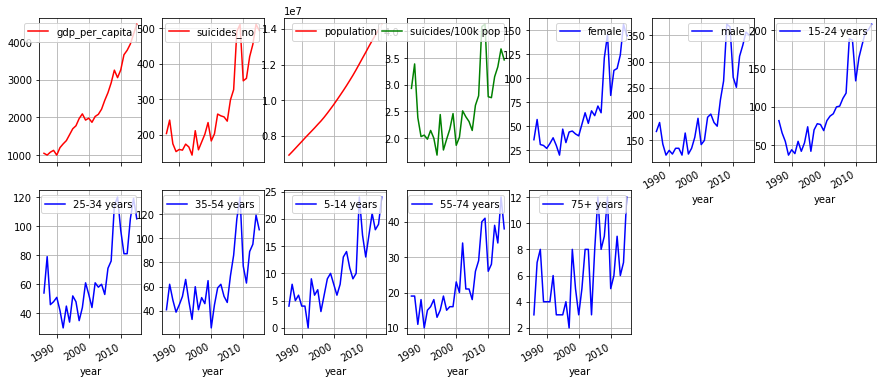

In [ ]:
features=Guatemala_suicides
features.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]

plt.show()

### Selección del tamaño de muestra de entrenamiento.


In [ ]:
train_set=features.iloc[:25, :]
#train_set.shape
test_set=features.iloc[25:30,:]
test_set.shape
#train_set.shape[0]

(5, 12)

### Estandarización de los datos

In [ ]:
TRAIN_SPLIT=train_set.shape[0]
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

## Modelo a un paso

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 4 #se usan los últimos 5 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 3], 0,  #la columna 4 es 'suicides/100k pop'
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, 30, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
#print ('Single window of past history : {}'.format(x_train_single[0].shape))
x_train_single.shape # (19 obs restantes, ultimas 5 obs para predecir, 12 variables)
x_val_single.shape
y_val_single.shape

(1,)

In [ ]:
BATCH_SIZE=2 # 6 Lotes de 4 filas o registros 
BUFFER_SIZE=1000

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
train_data_single
val_data_single

<RepeatDataset shapes: ((None, 4, 12), (None,)), types: (tf.float64, tf.float64)>

## Capas 

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(60,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

In [ ]:
x_train_single.shape[-2:]

(4, 12)

In [ ]:
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
single_step_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 60)                17520     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 61        
Total params: 17,581
Trainable params: 17,581
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_data_single
train_data_single

<RepeatDataset shapes: ((None, 4, 12), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
EPOCHS=20
EVALUATION_INTERVAL=1
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Epoch 1/20
1/1 [==============================] - 0s 365ms/step - loss: 0.7151 - val_loss: 1.2866
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.4378 - val_loss: 1.1835
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2518 - val_loss: 0.5763
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 0.1773 - val_loss: 0.5667
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5748 - val_loss: 0.5629
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2072 - val_loss: 0.4854
Epoch 7/20
1/1 [==============================] - 0s 9ms/step - loss: 0.2184 - val_loss: 0.4386
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 1.2209 - val_loss: 0.3315
Epoch 9/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5223 - val_loss: 0.4286
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3288 - val_loss: 0.5298
Epoch 11/20
1/1 [===============

In [ ]:
#### FUNCIÓN PARA GRAFICAR EL ENTRENAMIENTO DE UN PASO Y FUNCIÓN DE PÉRDIDA
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

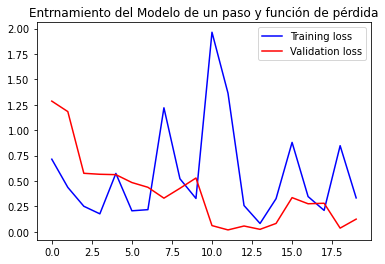

In [ ]:
plot_train_history(single_step_history,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
#### FUNCIÓN PARA GRAFICAR DATOS HISTÓRICOS Y PREDICCIÓN
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

# PREDICCIÓN A UN PASO 

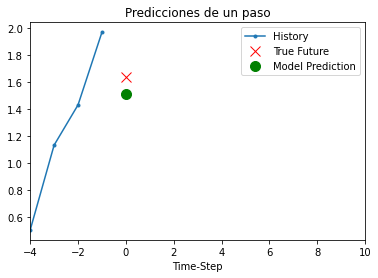

In [ ]:
for x, y in val_data_single.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Predicciones de un paso')
  plot.show()

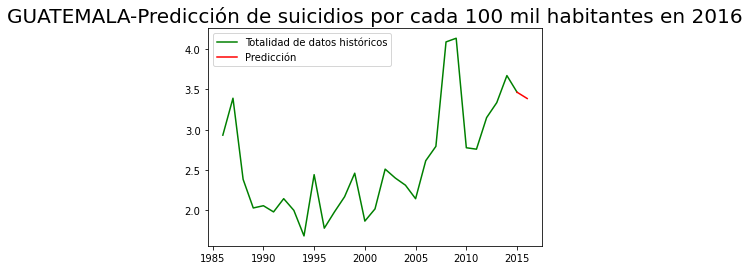

In [ ]:
N=len(Guatemala_suicides.index)-1
new_index=np.append(Guatemala_suicides.index, Guatemala_suicides.index[N]+1)
new_pred=single_step_model.predict(x)[0]*data_std[3]+data_mean[3]
new_suicides_rate=np.append(Guatemala_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("GUATEMALA-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# BRASIL

In [ ]:
brazil_suicides=data[data.country=="Brazil"]
brazil_suicides=brazil_suicides.drop(['country'],axis='columns')
brazil_suicides=brazil_suicides.drop([1985],axis=0)
brazil_suicides.shape
brazil_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,2257,4271,118776400.0,3.595832,1154,3117,1016,1011,1302,62,744,136
1987,2394,4672,122822467.0,3.803864,1163,3509,1004,1131,1449,67,844,177


In [ ]:
featuresB=brazil_suicides
#featuresB.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
#    layout=(3, 7), sharex=True, sharey=False, legend=False,    
#    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
#[ax.legend(loc=1) for ax in plt.gcf().axes]

#plt.show()

In [ ]:
featuresB=brazil_suicides
train_setB=featuresB.iloc[:25, :]
test_setB=featuresB.iloc[25:30,:]
test_setB.shape

(5, 12)

In [ ]:
TRAIN_SPLITB=train_setB.shape[0]
datasetB = featuresB.values
data_meanB = datasetB[:TRAIN_SPLITB].mean(axis=0)
data_stdB = datasetB[:TRAIN_SPLITB].std(axis=0)
datasetB = (datasetB-data_meanB)/data_stdB

In [ ]:
past_history = 4 #se usan los últimos 5 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleB, y_train_singleB = multivariate_data(datasetB, datasetB[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITB, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleB, y_val_singleB = multivariate_data(datasetB, datasetB[:, 3],
                                               TRAIN_SPLITB, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
BATCH_SIZE=2 
BUFFER_SIZE=1000

train_data_singleB = tf.data.Dataset.from_tensor_slices((x_train_singleB, y_train_singleB))
train_data_singleB = train_data_singleB.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleB = tf.data.Dataset.from_tensor_slices((x_val_singleB, y_val_singleB))
val_data_singleB = val_data_singleB.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_modelB = tf.keras.models.Sequential()
single_step_modelB.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleB.shape[-2:]))
#single_step_modelB.add(tf.keras.layers.LSTM(20)) ,return_sequences=True
#single_step_modelB.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40,input_shape=x_train_singleB.shape[-2:])))
single_step_modelB.add(tf.keras.layers.Dense(1))

In [ ]:
single_step_modelB.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
#tf.keras.optimizers.RMSprop()

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyB = single_step_modelB.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 411ms/step - loss: 0.3802 - val_loss: 2.9512
Epoch 2/30
1/1 [==============================] - 0s 11ms/step - loss: 0.3356 - val_loss: 2.9926
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 1.5328 - val_loss: 2.5923
Epoch 4/30
1/1 [==============================] - 0s 21ms/step - loss: 0.9381 - val_loss: 2.5263
Epoch 5/30
1/1 [==============================] - 0s 11ms/step - loss: 0.4057 - val_loss: 2.4663
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.9967 - val_loss: 2.1472
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 0.4158 - val_loss: 2.0124
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.7583 - val_loss: 1.7495
Epoch 9/30
1/1 [==============================] - 0s 12ms/step - loss: 0.5482 - val_loss: 1.4903
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.1839 - val_loss: 1.3968
Epoch 11/30
1/1 [===========

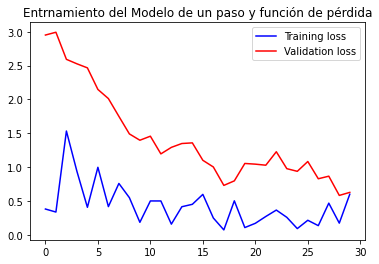

In [ ]:
plot_train_history(single_step_historyB,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

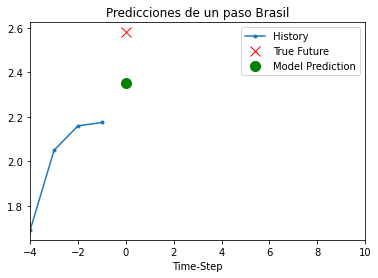

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelB.predict(x)[0]+0.4], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

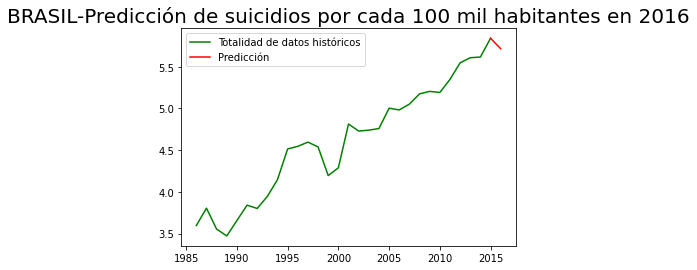

In [ ]:
N=len(brazil_suicides.index)-1
new_index=np.append(brazil_suicides.index, brazil_suicides.index[N]+1)
new_pred=(single_step_modelB.predict(x)[0]+0.4)*data_stdB[3]+data_meanB[3]
new_suicides_rate=np.append(brazil_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("BRASIL-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

In [ ]:
model_gru = tf.keras.models.Sequential()
model_gru.add(tf.keras.layers.GRU(60,input_shape=x_train_singleB.shape[-2:]))
#model_gru.add(tf.keras.layers.GRU(20)) ,return_sequences=True
model_gru.add(tf.keras.layers.Dense(1))
model_gru.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyBgru = model_gru.fit(train_data_singleB, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleB,
                                        validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 392ms/step - loss: 1.0835 - val_loss: 2.2823
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 1.0806 - val_loss: 1.6755
Epoch 3/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7260 - val_loss: 1.1485
Epoch 4/30
1/1 [==============================] - 0s 14ms/step - loss: 0.3335 - val_loss: 1.1413
Epoch 5/30
1/1 [==============================] - 0s 13ms/step - loss: 0.3640 - val_loss: 0.9960
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 0.1861 - val_loss: 0.9736
Epoch 7/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5543 - val_loss: 1.0388
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5165 - val_loss: 1.1553
Epoch 9/30
1/1 [==============================] - 0s 11ms/step - loss: 0.5961 - val_loss: 1.3557
Epoch 10/30
1/1 [==============================] - 0s 14ms/step - loss: 0.4768 - val_loss: 0.7643
Epoch 11/30
1/1 [===========

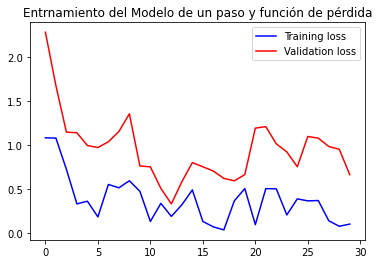

In [ ]:
plot_train_history(single_step_historyBgru,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

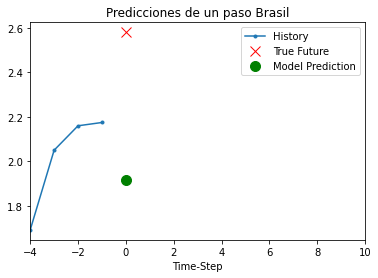

In [ ]:
for x, y in val_data_singleB.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    model_gru.predict(x)[0]], 0,
                   'Predicciones de un paso Brasil')
  plot.show()

#CHILE

In [ ]:
chile_suicides=data[data.country=="Chile"]
chile_suicides=chile_suicides.drop(['country'],axis='columns')
chile_suicides=chile_suicides.drop([1985],axis=0)
chile_suicides.shape
chile_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1728,654,10931700.0,5.982601,122,532,145,150,193,11,131,24
1987,1985,693,11209000.0,6.182532,125,568,154,176,194,7,143,19


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


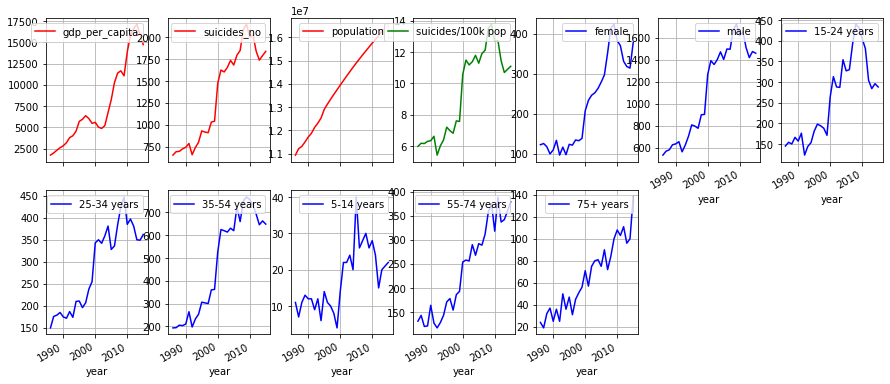

In [ ]:
featuresCH=chile_suicides
featuresCH.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [ ]:
featuresCH=chile_suicides
train_setCH=featuresCH.iloc[:25, :]
test_setCH=featuresCH.iloc[25:30,:]
test_setCH.shape

(5, 12)

In [ ]:
TRAIN_SPLITCH=train_setCH.shape[0]
datasetCH = featuresCH.values
data_meanCH = datasetCH[:TRAIN_SPLITCH].mean(axis=0)
data_stdCH = datasetCH[:TRAIN_SPLITCH].std(axis=0)
datasetCH = (datasetCH-data_meanCH)/data_stdCH

In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleCH, y_train_singleCH = multivariate_data(datasetCH, datasetCH[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITCH, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleCH, y_val_singleCH = multivariate_data(datasetCH, datasetCH[:, 3],
                                               TRAIN_SPLITCH, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleCH = tf.data.Dataset.from_tensor_slices((x_train_singleCH, y_train_singleCH))
train_data_singleCH = train_data_singleCH.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleCH = tf.data.Dataset.from_tensor_slices((x_val_singleCH, y_val_singleCH))
val_data_singleCH = val_data_singleCH.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_modelCH = tf.keras.models.Sequential()
single_step_modelCH.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleCH.shape[-2:]))
single_step_modelCH.add(tf.keras.layers.Dense(1))
single_step_modelCH.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyCH = single_step_modelCH.fit(train_data_singleCH, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleCH,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 442ms/step - loss: 1.7240 - val_loss: 1.0579
Epoch 2/30
1/1 [==============================] - 0s 15ms/step - loss: 0.8911 - val_loss: 0.9765
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 0.4920 - val_loss: 0.8839
Epoch 4/30
1/1 [==============================] - 0s 12ms/step - loss: 0.6565 - val_loss: 0.8691
Epoch 5/30
1/1 [==============================] - 0s 12ms/step - loss: 0.1887 - val_loss: 0.8258
Epoch 6/30
1/1 [==============================] - 0s 13ms/step - loss: 1.2532 - val_loss: 0.6999
Epoch 7/30
1/1 [==============================] - 0s 14ms/step - loss: 0.2440 - val_loss: 0.7025
Epoch 8/30
1/1 [==============================] - 0s 13ms/step - loss: 0.4237 - val_loss: 0.7246
Epoch 9/30
1/1 [==============================] - 0s 12ms/step - loss: 0.3066 - val_loss: 0.6586
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.8599 - val_loss: 0.4068
Epoch 11/30
1/1 [===========

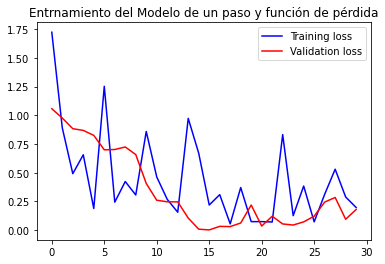

In [ ]:
plot_train_history(single_step_historyCH,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

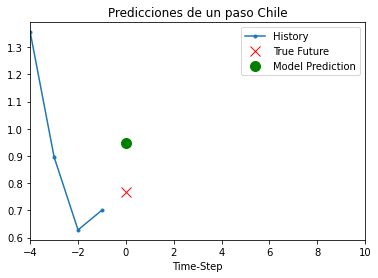

In [ ]:

for x, y in val_data_singleCH.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelCH.predict(x)[0]], 0,
                   'Predicciones de un paso Chile')
  plot.show()

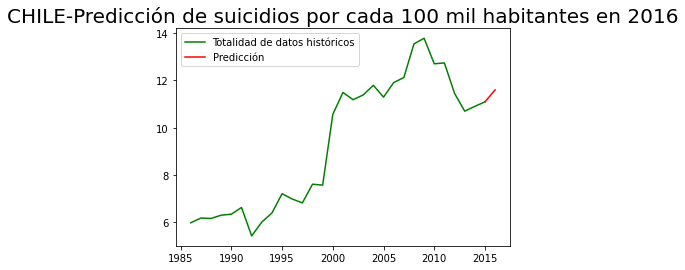

In [ ]:
N=len(chile_suicides.index)-1
new_index=np.append(chile_suicides.index, chile_suicides.index[N]+1)
new_pred=(single_step_modelCH.predict(x)[0])*data_stdCH[3]+data_meanCH[3]
new_suicides_rate=np.append(chile_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("CHILE-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# ECUADOR

In [ ]:
ecuador_suicides=data[data.country=="Ecuador"]
ecuador_suicides=ecuador_suicides.drop(['country'],axis='columns')
ecuador_suicides=ecuador_suicides.drop([1985],axis=0)
#ecuador_suicides.shape
ecuador_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1986,1943,377,7881300.0,4.783475,131,246,161,95,64,12,35,10
1987,1669,390,8356800.0,4.666858,131,259,157,100,89,12,25,7


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


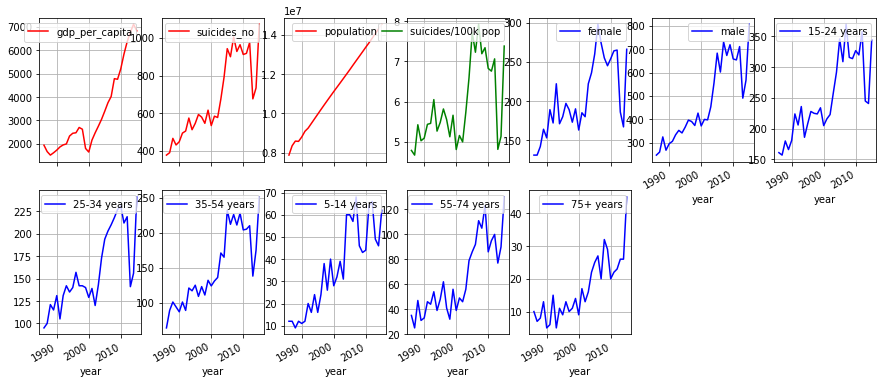

In [ ]:
featuresEC=ecuador_suicides
featuresEC.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [ ]:
featuresEC=ecuador_suicides
train_setEC=featuresEC.iloc[:25, :]
test_setEC=featuresEC.iloc[25:30,:]
test_setEC.shape

(5, 12)

In [ ]:
TRAIN_SPLITEC=train_setEC.shape[0]
datasetEC = featuresEC.values
data_meanEC = datasetEC[:TRAIN_SPLITEC].mean(axis=0)
data_stdEC = datasetEC[:TRAIN_SPLITEC].std(axis=0)
datasetEC = (datasetEC-data_meanEC)/data_stdEC


In [ ]:
past_history = 4 #se usan los últimos 4 datos para predecir a un paso.
future_target = 0 
STEP = 1
x_train_singleEC, y_train_singleEC = multivariate_data(datasetEC, datasetEC[:, 3], 0,  #la columna 3 es 'suicides/100k pop'
                                                   TRAIN_SPLITEC, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_singleEC, y_val_singleEC = multivariate_data(datasetEC, datasetEC[:, 3],
                                               TRAIN_SPLITEC, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_singleEC = tf.data.Dataset.from_tensor_slices((x_train_singleEC, y_train_singleEC))
train_data_singleEC = train_data_singleEC.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_singleEC = tf.data.Dataset.from_tensor_slices((x_val_singleEC, y_val_singleEC))
val_data_singleEC = val_data_singleEC.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_modelEC = tf.keras.models.Sequential()
single_step_modelEC.add(tf.keras.layers.LSTM(60,input_shape=x_train_singleEC.shape[-2:]))
single_step_modelEC.add(tf.keras.layers.Dense(1))
single_step_modelEC.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
EPOCHS=30
EVALUATION_INTERVAL=1
single_step_historyEC = single_step_modelEC.fit(train_data_singleEC, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_singleEC,
                                            validation_steps=1)

Epoch 1/30
1/1 [==============================] - 0s 403ms/step - loss: 0.6736 - val_loss: 1.2106
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 1.0366 - val_loss: 1.0530
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 0.6990 - val_loss: 0.9488
Epoch 4/30
1/1 [==============================] - 0s 8ms/step - loss: 0.7160 - val_loss: 0.9288
Epoch 5/30
1/1 [==============================] - 0s 7ms/step - loss: 0.5441 - val_loss: 0.8454
Epoch 6/30
1/1 [==============================] - 0s 8ms/step - loss: 0.9992 - val_loss: 0.6351
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 0.3590 - val_loss: 0.6688
Epoch 8/30
1/1 [==============================] - 0s 8ms/step - loss: 0.8299 - val_loss: 0.6320
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 0.3712 - val_loss: 0.6763
Epoch 10/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0195 - val_loss: 0.6419
Epoch 11/30
1/1 [===================

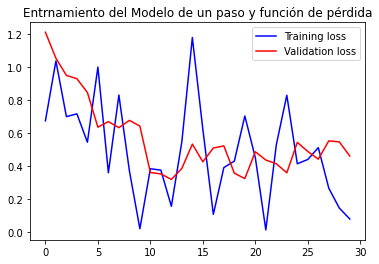

In [ ]:
plot_train_history(single_step_historyEC,
                   'Entrnamiento del Modelo de un paso y función de pérdida')

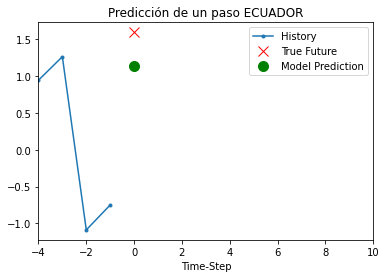

In [ ]:
for x, y in val_data_singleEC.take(1):
  plot = show_plot([x[0][:, 3].numpy(), y[0].numpy(),
                    single_step_modelEC.predict(x)[0]], 0,
                   'Predicción de un paso ECUADOR')
  plot.show()


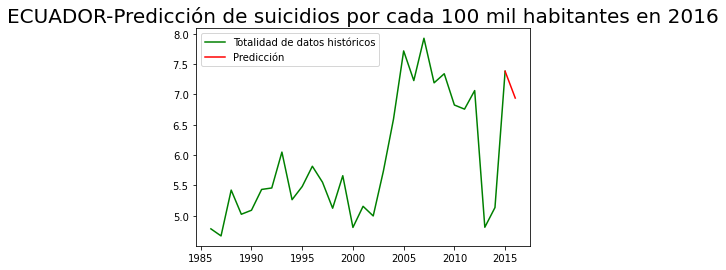

In [ ]:
N=len(ecuador_suicides.index)-1
new_index=np.append(ecuador_suicides.index, ecuador_suicides.index[N]+1)
new_pred=(single_step_modelEC.predict(x)[0])*data_stdEC[3]+data_meanEC[3]
new_suicides_rate=np.append(ecuador_suicides['suicides/100k pop'],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N+1], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N:],label='Predicción',color='r')
plt.title("ECUADOR-Predicción de suicidios por cada 100 mil habitantes en 2016", size = 20)
plt.legend()
plt.show()

# COSTA RICA

In [ ]:
costar_suicides=data[data.country=="Costa Rica"]
costar_suicides=costar_suicides.drop(['country'],axis='columns')
#costar_suicides=costar_suicides.drop([1985],axis=0)
costar_suicides.shape
costar_suicides.head(2)

,gdp_per_capita,suicides_no,population,suicides/100k pop,female,male,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
year,,,,,,,,,,,,
1985,2145,128,2236200.0,5.723996,16,112,41,35,35,3,13,1
1986,2389,131,2292900.0,5.713289,13,118,27,28,50,2,21,3


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


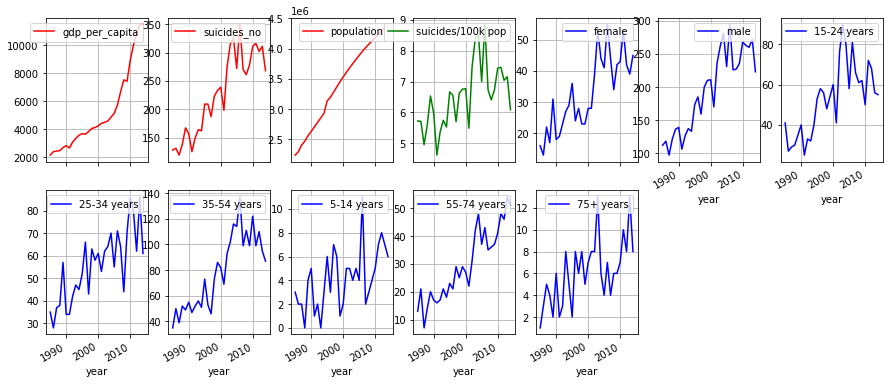

In [ ]:
featuresCR=costar_suicides
featuresCR.plot(kind='line', figsize=(15,10), subplots=True, grid=True,
    layout=(3, 7), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'b', 'b', 'b', 'b', 'b', 'b', 'b','b','b','b','b','b','b','b'])
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [ ]:
featuresCR=costar_suicides
train_setCR=featuresCR.iloc[:24, :]
test_setCR=featuresCR.iloc[24:30,:]
test_setCR.shape

(6, 12)

In [ ]:
TRAIN_SPLITCR=train_setCR.shape[0]
datasetCR = featuresCR.values
data_meanCR = datasetCR[:TRAIN_SPLITCR].mean(axis=0)
data_stdCR = datasetCR[:TRAIN_SPLITCR].std(axis=0)
datasetCR = (datasetCR-data_meanCR)/data_stdCR

In [ ]:
past_history = 3
future_target = 2
STEP=1
x_train_multiCR, y_train_multiCR = multivariate_data(datasetCR, datasetCR[:, 3], 0,
                                                 TRAIN_SPLITCR, past_history,
                                                 future_target, STEP)
x_val_multiCR, y_val_multiCR = multivariate_data(datasetCR, datasetCR[:, 3],
                                             TRAIN_SPLITCR, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multiCR[0].shape))
print ('\n Target suicides for 100kp to predict : {}'.format(y_train_multiCR[0].shape))

Single window of past history : (3, 12)

 Target suicides for 100kp to predict : (2,)


In [ ]:
BATCH_SIZE=2
BUFFER_SIZE=1000

train_data_multiCR = tf.data.Dataset.from_tensor_slices((x_train_multiCR, y_train_multiCR))
train_data_multiCR = train_data_multiCR.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multiCR = tf.data.Dataset.from_tensor_slices((x_val_multiCR, y_val_multiCR))
val_data_multiCR = val_data_multiCR.batch(BATCH_SIZE).repeat()

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

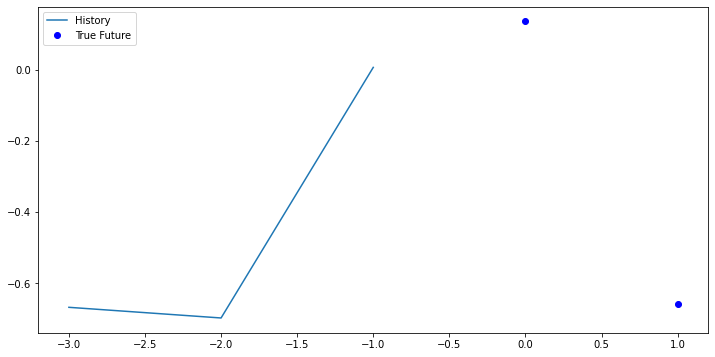

In [ ]:
for x, y in train_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_modelCR = tf.keras.models.Sequential()
multi_step_modelCR.add(tf.keras.layers.LSTM(60,
                                          return_sequences=True,
                                          input_shape=x_train_multiCR.shape[-2:]))
multi_step_modelCR.add(tf.keras.layers.LSTM(30, activation='relu'))
multi_step_modelCR.add(tf.keras.layers.Dense(2))

multi_step_modelCR.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
EPOCHS=100
multi_step_historyCR = multi_step_modelCR.fit(train_data_multiCR, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multiCR,
                                          validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 463ms/step - loss: 0.5985 - val_loss: 0.6675
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 1.0510 - val_loss: 0.6575
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 0.4281 - val_loss: 0.6594
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.9312 - val_loss: 0.6226
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.7736 - val_loss: 0.5628
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6960 - val_loss: 0.5647
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.9559 - val_loss: 0.5641
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 1.1675 - val_loss: 0.5419
Epoch 9/100
1/1 [==============================] - 0s 9ms/step - loss: 0.7244 - val_loss: 0.5089
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.3158 - val_loss: 0.5091
Epoch 11/100
1/1 [====

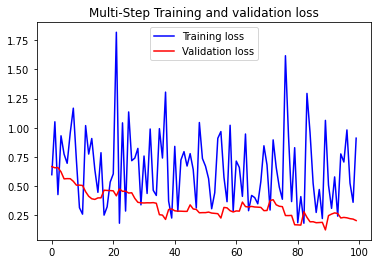

In [ ]:
plot_train_history(multi_step_historyCR, 'Multi-Step Training and validation loss')

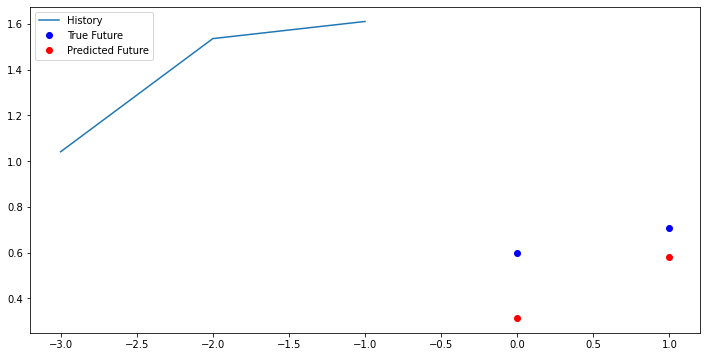

In [ ]:
for x, y in val_data_multiCR.take(1):
  multi_step_plot(x[0], y[0], multi_step_modelCR.predict(x)[0])

In [ ]:
new_data
new_data[:N]
new_data[N:]

,new_suicides_rate
2015,6.736043
2016,7.020012


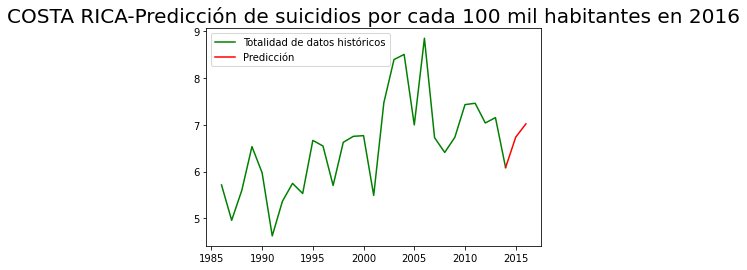

In [ ]:
N=len(costar_suicides.index)-1
new_index=np.append(costar_suicides.index[1:30],[costar_suicides.index[N]+1,costar_suicides.index[N]+2])
new_pred=(multi_step_modelCR.predict(x)[0]*data_stdCR[3])+data_meanCR[3]
new_suicides_rate=np.append(costar_suicides['suicides/100k pop'][1:30],new_pred)
new_data=pd.DataFrame({'new_suicides_rate':new_suicides_rate},index=new_index)
plt.plot(new_data[:N], color='g', label='Totalidad de datos históricos')
plt.plot(new_data[N-1:],label='Predicción',color='r')
plt.title("COSTA RICA-Predicción de suicidios por cada 100 mil habitantes en 2015 y 2016", size = 20)
plt.legend()
plt.show()

# COLOMBIA